In [1]:
import numpy as np
import matplotlib
import h5py, glob, argparse
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)
from matplotlib.colors import LogNorm
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
from matplotlib.backends.backend_pdf import PdfPages
import emoji
import json
import os

In [2]:
_old_axes_init = Axes.__init__


def _new_axes_init(self, *a, **kw):
    _old_axes_init(self, *a, **kw)
    # https://matplotlib.org/stable/gallery/misc/zorder_demo.html
    # 3 => leave text and legends vectorized
    self.set_rasterization_zorder(3)


def rasterize_plots():
    Axes.__init__ = _new_axes_init
    
rasterize_plots()

In [3]:
## No Spiking Example: ##
input_file = '/global/cfs/cdirs/dune/www/data/2x2/nearline_run2/flowed_light/cosmics_bin15/mpd_run_data_rctl_984_p6.FLOW.hdf5'
## Module 1 Spiking Example: ##
#input_file = '/global/cfs/cdirs/dune/www/data/2x2/nearline_run2/flowed_light/cosmics_hvramp_down_12162025/mpd_run_data_rctl_987_p6.FLOW.hdf5'
## Module 3 Spiking Example: ##
#input_file = '/global/cfs/cdirs/dune/www/data/2x2/nearline_run2/flowed_light/source_dtg_bin1/two_trig_40us_period_500tick/intensity_scan/hv_60kV_beamC_20uA/decays/mpd_run_data_rctl_967_p42.FLOW.hdf5'

In [4]:
## define system constants ##
SAMPLE_RATE = 0.016 # us
BIT = 4  # factor from unused ADC bits on LRS: would be nice to have in a resource .yaml
PRE_NOISE = 50 # Will need to be re-defined once we know beam timing
THRESHOLD = 600 # For the FFT, used to define events with signal peaks
SAT = 32767
EXPECTED_RATE = 60 # In Hz, obviously depends on subrun conditions
RATE_THD = 20 # Hz over expected trigger rate considered allowable
    
sipm_channels = ([4,5,6,7,8,9] + \
                 [10,11,12,13,14,15] + \
                 [20,21,22,23,24,25] + \
                 [26,27,28,29,30,31] + \
                 [36,37,38,39,40,41] + \
                 [42,43,44,45,46,47] + \
                 [52,53,54,55,56,57] + \
                 [58,59,60,61,62,63])

In [5]:
## open file ##
file = h5py.File(input_file, 'r')
size_bytes = os.path.getsize(input_file)
size_gb = size_bytes / (1024 ** 3)
print(f"File size: {size_gb:.2f} GB")

MULT = int(size_gb // 3)
if MULT < 1:
    MULT = 1
print(f"Using MULT = {MULT} for data reduction.")

File size: 2.55 GB
Using MULT = 1 for data reduction.


In [6]:

## first let's start with skipping events ##
## then we repeat for a continuous region ##
## define the light waveform matrix ##
wvfm = file["light/wvfm/data"]['samples'][::MULT,:,:,:]
time_stamp = file["light/events/data"]['tai_ns'][::MULT] - np.min(file["light/events/data"]['tai_ns'][::MULT])
file_length = (np.max(file["light/events/data"]['tai_ns'][::MULT]) - np.min(file["light/events/data"]['tai_ns'][::MULT])) / 1e9
print(f"File length: {file_length:.2f} seconds")
print(wvfm.shape)

## convert to US Central Time b/c FNAL ##
utc_ns = np.min(file["light/events/data"]['tai_ns'][::MULT])
utc_seconds = utc_ns / 1e9
dt_utc = datetime.fromtimestamp(utc_seconds, tz=timezone.utc)
dt_central = dt_utc.astimezone(ZoneInfo("America/Chicago"))
formatted_time = dt_central.strftime("%Y-%m-%d %H:%M:%S %Z")

## mask out inactive channels and remove pedestals ##
## we remove the unused ADC bits to lighten the load ##
light_wvfms_ped = wvfm[:,:,sipm_channels,:] / BIT
del wvfm

## use a simple method for baselining because we want to tag HV issues ##
## and HV issues should span the entire waveform ##
light_wvfms = light_wvfms_ped.astype(float) - light_wvfms_ped[:,:,:50].mean(axis=-1, keepdims=True)
SAMPLES = np.shape(light_wvfms)[-1]
del light_wvfms_ped

File length: 180.77 seconds
(4446, 8, 64, 600)


In [7]:
subsequent_ts = (time_stamp) / 1e4
event_ids = np.arange(len(subsequent_ts))


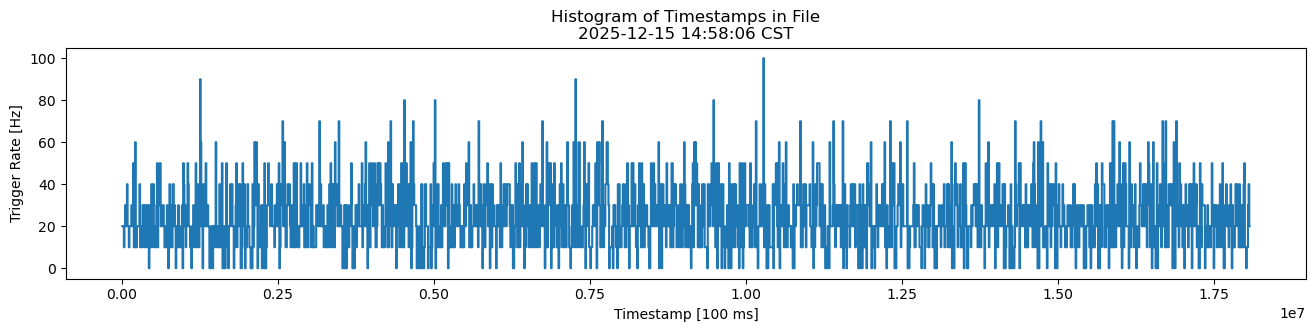

In [8]:
fig = plt.figure(figsize=(16, 3))
hist, binning = np.histogram(subsequent_ts[:,6], bins=np.unique(np.linspace(np.min(subsequent_ts[:,6]), np.max(subsequent_ts[:,6]), num=int(file_length*10))))
bin_width = binning[1] - binning[0]
plt.step(binning[1:], hist*10*MULT, fillstyle='full', where='mid')
plt.xlabel('Timestamp [100 ms]')
plt.ylabel('Trigger Rate [Hz]')
plt.title(f'Histogram of Timestamps in File\n{formatted_time}')
plt.show()

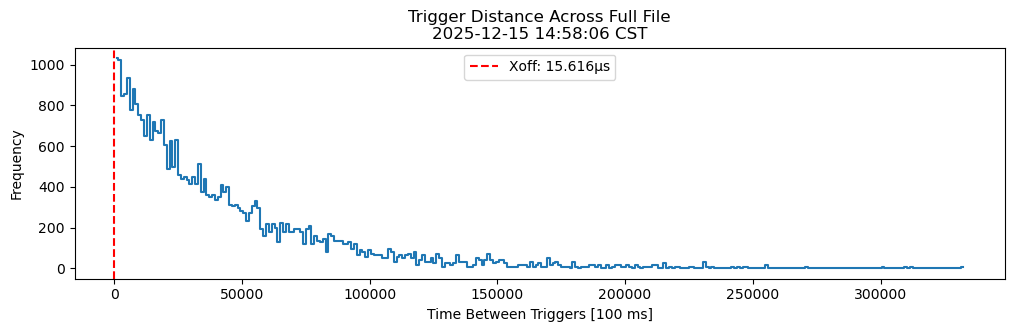

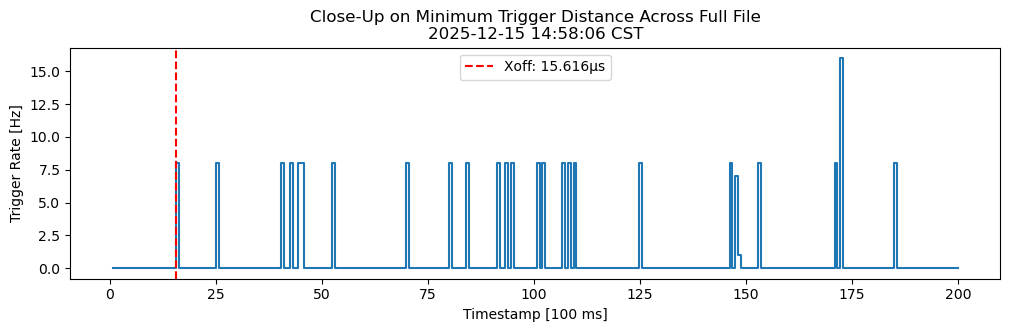

In [9]:
reset_times = (file["light/events/data"]['tai_ns'][1:] - file["light/events/data"]['tai_ns'][:-1]) / 1e3 # put it in us
fig = plt.figure(figsize=(12, 3))
hist, binning = np.histogram(reset_times, bins=np.linspace(0, np.max(reset_times), 300))
bin_width = binning[1] - binning[0]
plt.step(binning[1:], hist, fillstyle='full', where='mid')
plt.axvline(x=min(reset_times[reset_times>0]), color='r', linestyle='--', label=f'Xoff: {min(reset_times[reset_times>0])}μs')
plt.xlabel('Time Between Triggers [100 ms]')
plt.ylabel('Frequency')
plt.title(f'Trigger Distance Across Full File\n{formatted_time}')
plt.legend(loc='upper center')
plt.show()

fig = plt.figure(figsize=(12, 3))
hist, binning = np.histogram(reset_times, bins=np.linspace(0, 200, 300), range=(0,200))
bin_width = binning[1] - binning[0]
plt.step(binning[1:], hist, fillstyle='full', where='mid')
plt.axvline(x=min(reset_times[reset_times>0]), color='r', linestyle='--', label=f'Xoff: {min(reset_times[reset_times>0])}μs')
plt.xlabel('Timestamp [100 ms]')
plt.ylabel('Trigger Rate [Hz]')
plt.title(f'Close-Up on Minimum Trigger Distance Across Full File\n{formatted_time}')
plt.legend(loc='upper center')
plt.show()

In [10]:
MAX_HZ = np.max(hist)*10*MULT
MIN_HZ = np.min(hist)*10*MULT
if MIN_HZ==0:
    max_hz_loc = np.where(hist==0)[0][0]
    if max_hz_loc < 200:
        MAX_HZ_LOC = 0
    else:
        MAX_HZ_LOC = max_hz_loc - 200
else: 
    MAX_HZ_LOC = np.argmax(hist)
MAX_TS = int(binning[1:][MAX_HZ_LOC])
first_spike_idx = np.where((np.array(subsequent_ts[:,6], dtype=int) - MAX_TS) < bin_width)[0][0]

In [19]:
def trigger_timing(light_wvfms, events):
    
    adc_list = np.arange(np.shape(light_wvfms)[1])
    event_list = []
    time_list = []
    # you can choose to only care about a few adcs:
    adc_list = [0,1,2,3,4,5,6,7]
    Average = np.zeros((len(adc_list), 8, SAMPLES), dtype=np.float64)
    
    for adc in adc_list:

        transposed_wvfms = np.transpose(light_wvfms, (1, 2, 0, 3))[adc,:,:,:]
    
        fig, ax = plt.subplots(4, 2, figsize=(11.5, 7.5), sharex=True, layout='constrained')
        for summ in range(8):
            start = summ*6
            end = start+6
            flattened_wvfms = transposed_wvfms[start:end, :, :]

            chan = np.shape(flattened_wvfms)[0]
            for ev in events:
                if np.mean(flattened_wvfms[:,ev,:50]) < -25:
                    event_list.append(ev)
                    time_list.append(time_stamp[ev])
                    ax[summ//2, summ%2].plot(np.linspace(0,SAMPLES,SAMPLES), np.sum(flattened_wvfms[:,ev,:] - np.mean(flattened_wvfms[:,ev,:50]), axis=0), linewidth=0.8)
                    Average[adc,summ,:] += np.sum(flattened_wvfms[:,ev,:] - np.mean(flattened_wvfms[:,ev,:50]), axis=0) / (len(events))

                    ## to plot individual channels ##
                    #for i in range(chan):
                    #    ax[summ//2, summ%2].plot(np.linspace(0,SAMPLES,SAMPLES), flattened_wvfms[i,ev,:] - np.mean(flattened_wvfms[i,ev,:50]), linewidth=0.8) 
                    
            ax[summ//2, summ%2].set_title('ADC '+str(adc)+': Channels ['+str(sipm_channels[start])+':'+str(sipm_channels[end-1])+f']\n{formatted_time}')
            ax[summ//2, summ%2].grid(True)
            #ax[summ//2, summ%2].set_ylim(-2000, 12200) # to fix the y axis, if you like
            ax[summ//2, 0].set_ylabel('ADC Value')
            ax[3, summ%2].set_xlabel('Sample [0.016 μs]')

        plt.grid(True)
        rect = plt.Rectangle((0, 0), 1200, 800, fill=False, edgecolor='black', lw=2)
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))

        plt.legend(unique.values(), unique.keys())
        #fig.patches.append(rect)
        plt.show()
    return event_list, time_list, Average

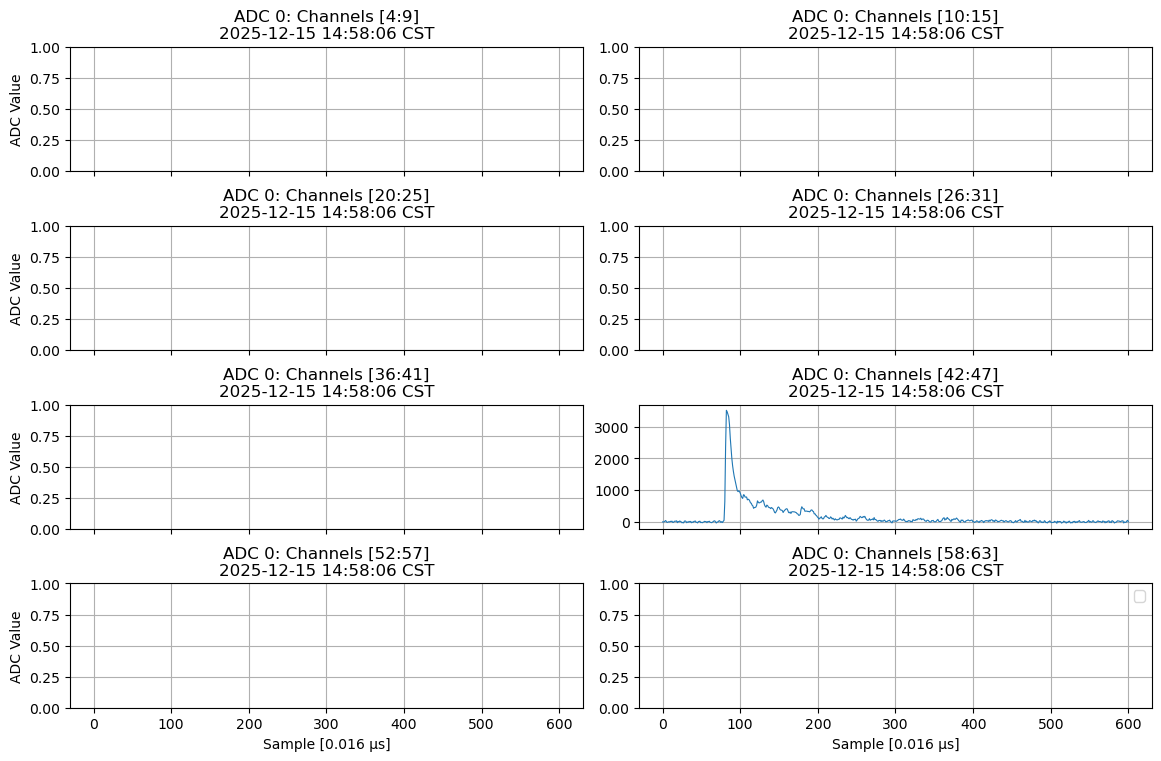

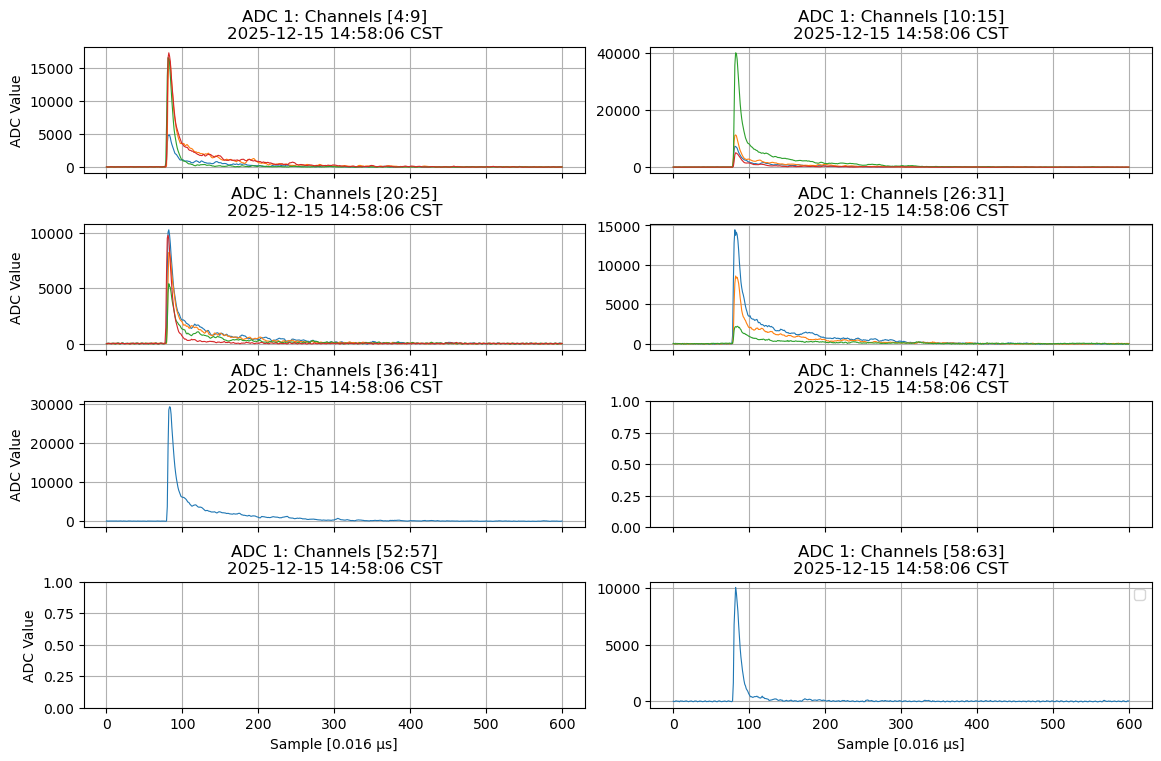

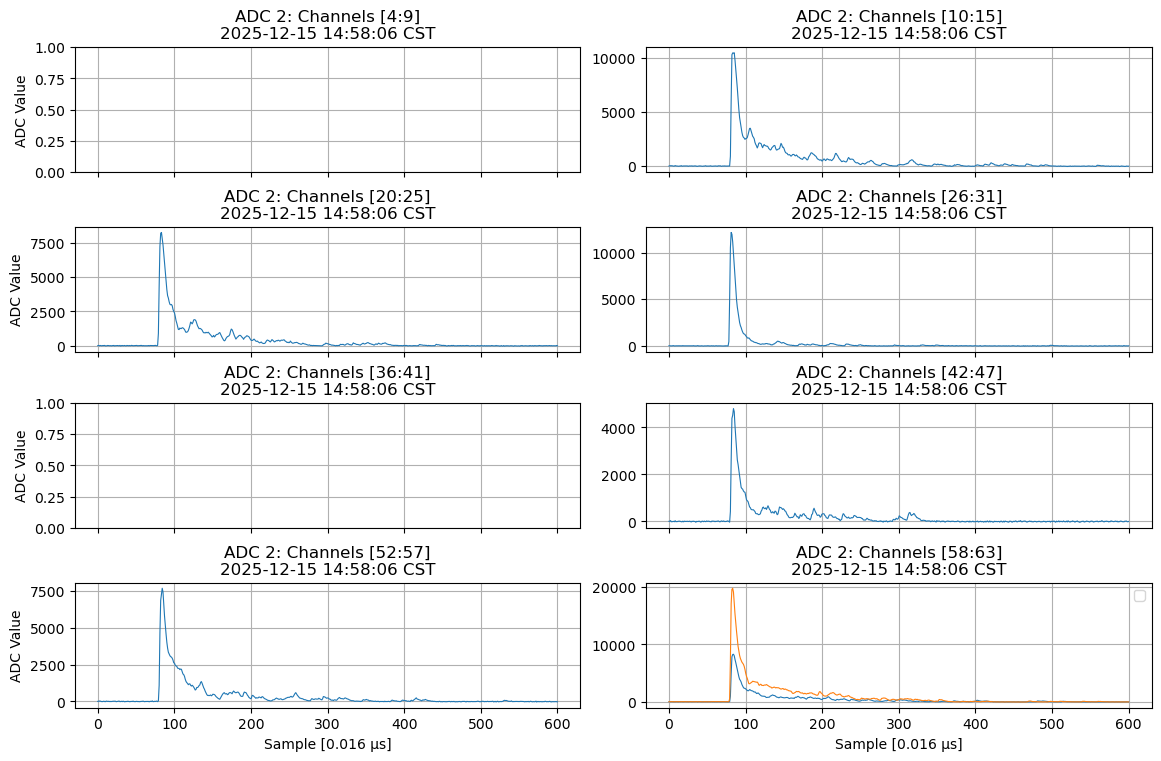

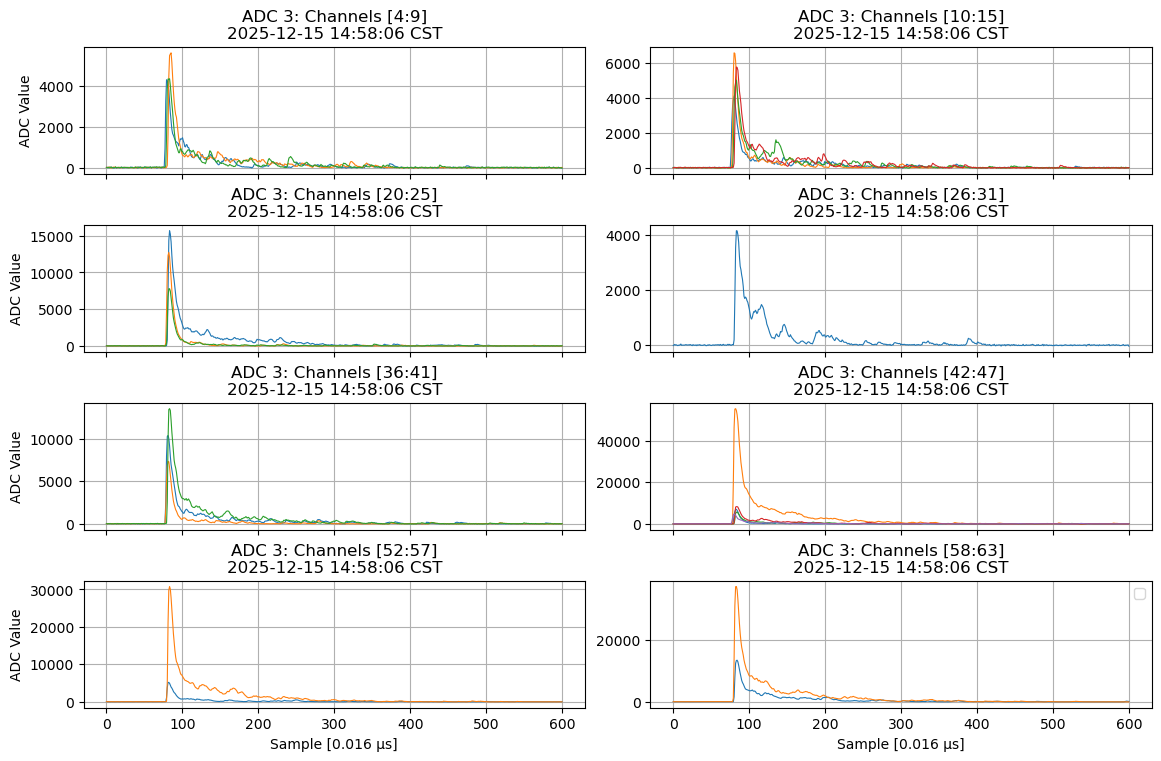

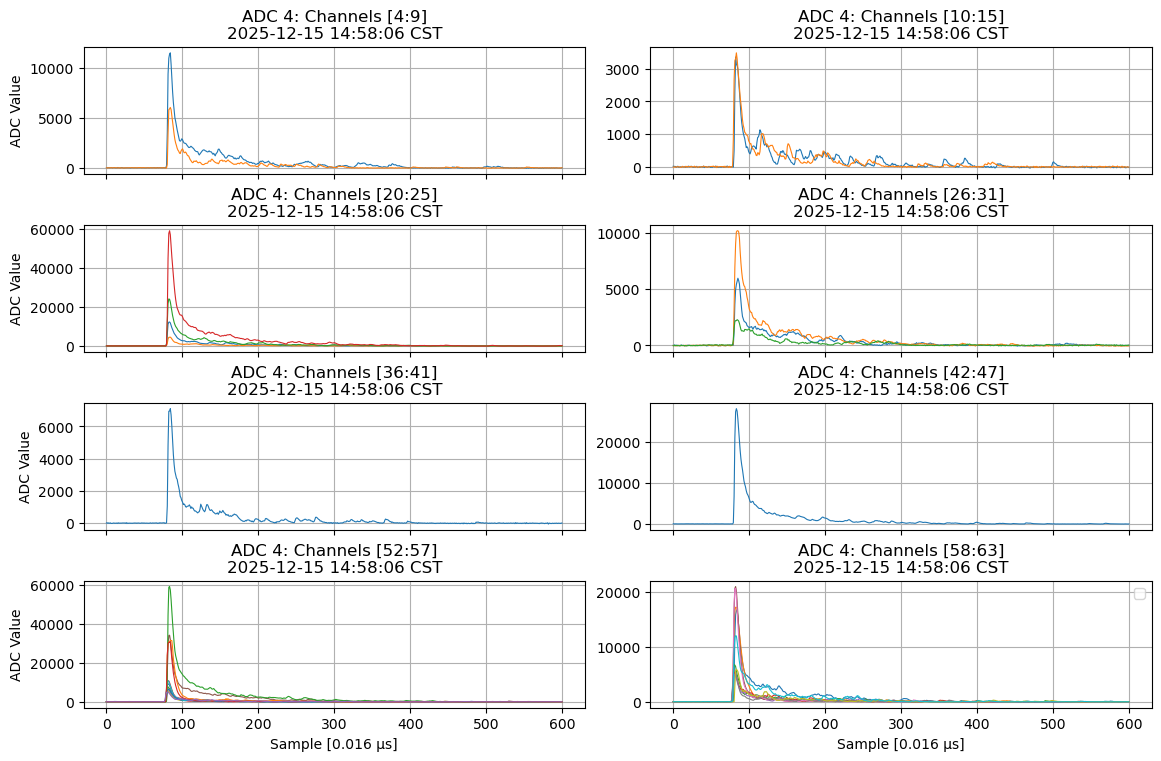

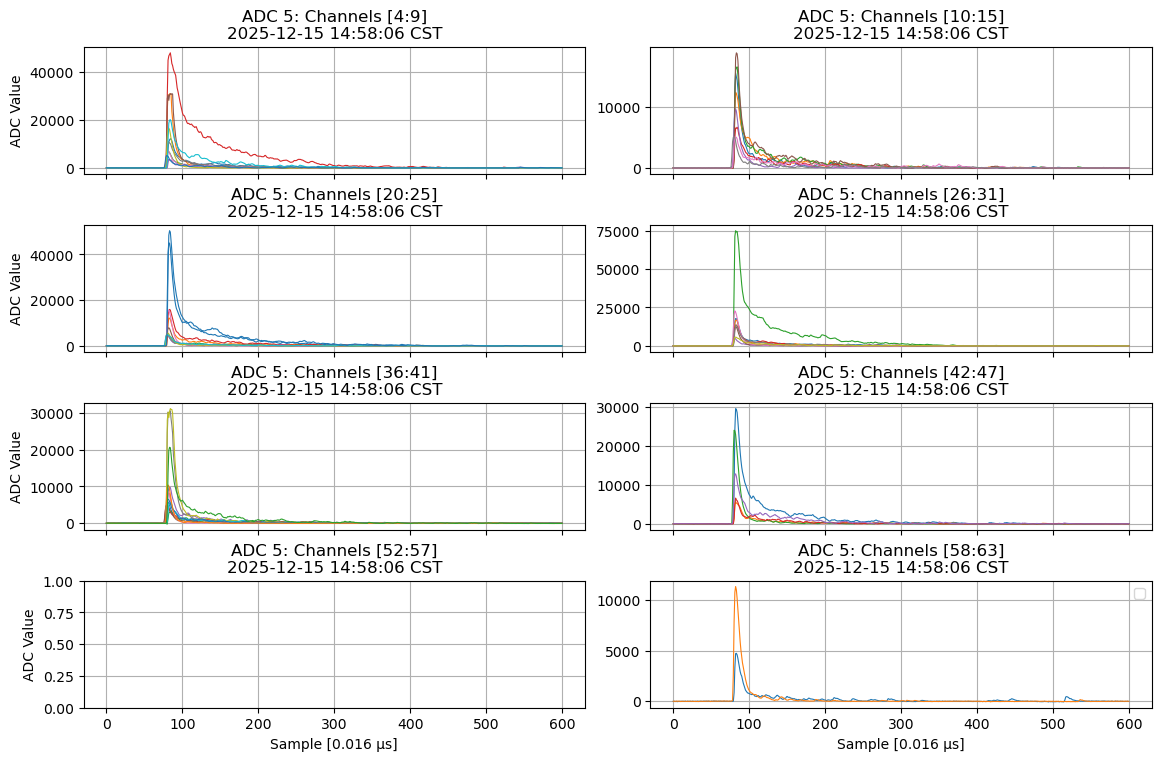

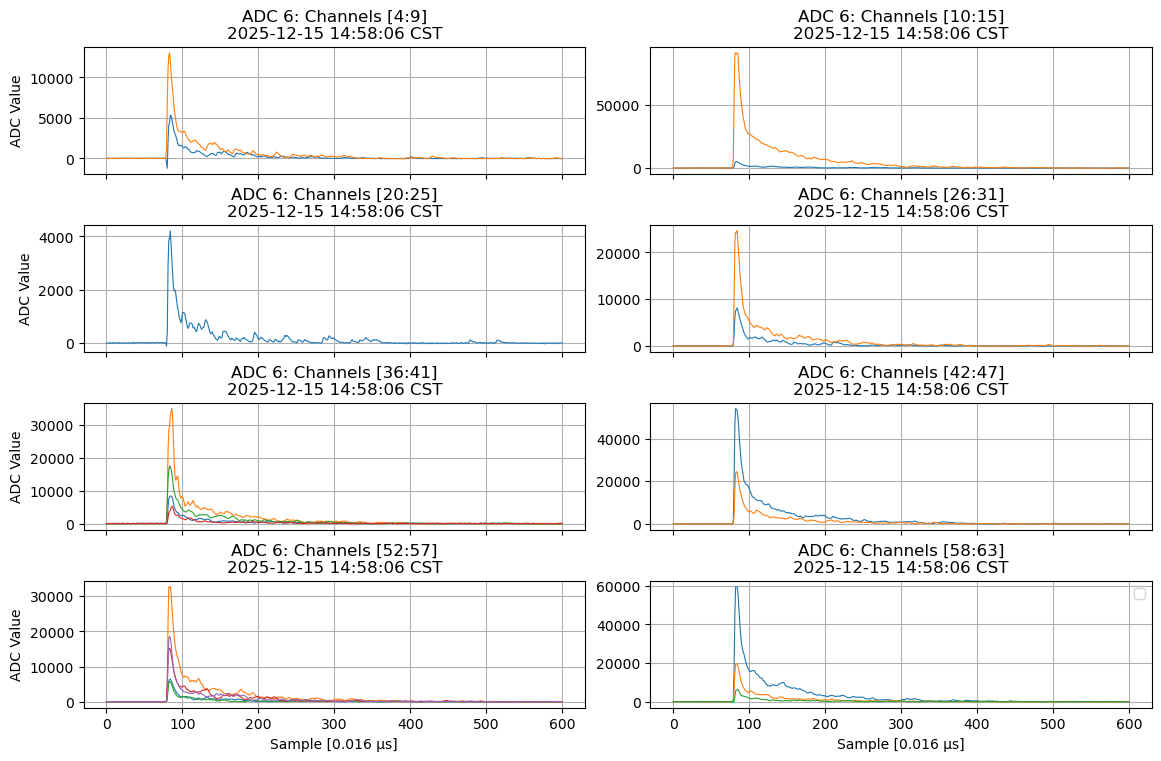

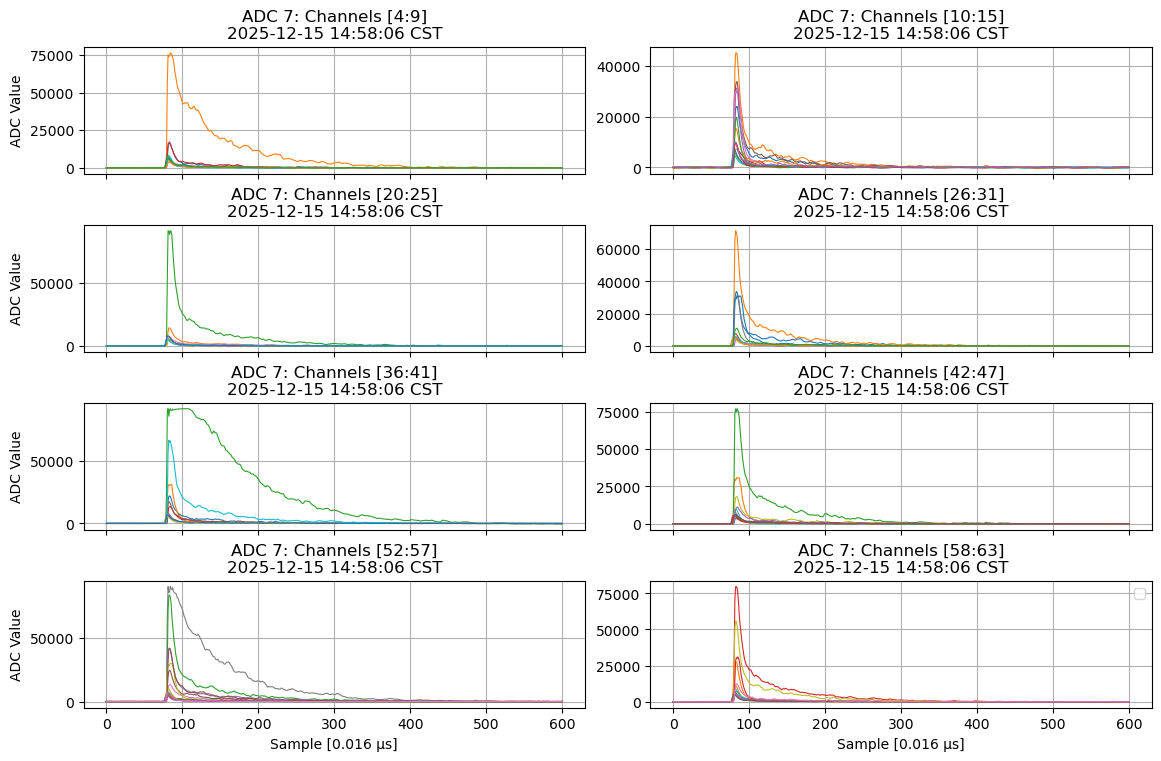

In [20]:
if np.shape(light_wvfms)[-1] > first_spike_idx+400:
    events = range(first_spike_idx,first_spike_idx+400,1)
else: 
    events = range(first_spike_idx,np.shape(light_wvfms)[-1],1)
event_list, time_list, average_wvfm = trigger_timing(light_wvfms, events)

In [13]:
## Optionally, you can plot sums of the above waveforms to look for paterns ##
'''
adc_list = [0,1,2,3,4,5,6,7]
for adc in adc_list:
        if max(average_wvfm[adc,:, :].flatten()) > 0:
            fig, ax = plt.subplots(4, 2, figsize=(11.5, 7.5), sharex=True, layout='constrained')
            for summ in range(8):
                start = summ*6
                end = start+6
                flattened_wvfms = average_wvfm[adc,summ, :]
                ax[summ//2, summ%2].plot(np.linspace(0,SAMPLES,SAMPLES), flattened_wvfms - np.mean(flattened_wvfms[:50]), linewidth=0.8)
                ax[summ//2, summ%2].set_title('ADC '+str(adc)+': Channels ['+str(sipm_channels[start])+':'+str(sipm_channels[end-1])+f']\n{formatted_time}')
                ax[summ//2, summ%2].grid(True)
                #ax[summ//2, summ%2].set_ylim(-2000, 12200)
                ax[summ//2, 0].set_ylabel('ADC Value')
                ax[3, summ%2].set_xlabel('Sample [0.016 μs]')

            plt.grid(True)
            rect = plt.Rectangle((0, 0), 1200, 800, fill=False, edgecolor='black', lw=2)
            handles, labels = plt.gca().get_legend_handles_labels()
            unique = dict(zip(labels, handles))

            plt.legend(unique.values(), unique.keys())
            #fig.patches.append(rect)
            plt.show()
'''

"\nadc_list = [0,1,2,3,4,5,6,7]\nfor adc in adc_list:\n        if max(average_wvfm[adc,:, :].flatten()) > 0:\n            fig, ax = plt.subplots(4, 2, figsize=(11.5, 7.5), sharex=True, layout='constrained')\n            for summ in range(8):\n                start = summ*6\n                end = start+6\n                flattened_wvfms = average_wvfm[adc,summ, :]\n                ax[summ//2, summ%2].plot(np.linspace(0,SAMPLES,SAMPLES), flattened_wvfms - np.mean(flattened_wvfms[:50]), linewidth=0.8)\n                ax[summ//2, summ%2].set_title('ADC '+str(adc)+': Channels ['+str(sipm_channels[start])+':'+str(sipm_channels[end-1])+f']\n{formatted_time}')\n                ax[summ//2, summ%2].grid(True)\n                #ax[summ//2, summ%2].set_ylim(-2000, 12200)\n                ax[summ//2, 0].set_ylabel('ADC Value')\n                ax[3, summ%2].set_xlabel('Sample [0.016 μs]')\n\n            plt.grid(True)\n            rect = plt.Rectangle((0, 0), 1200, 800, fill=False, edgecolor='blac

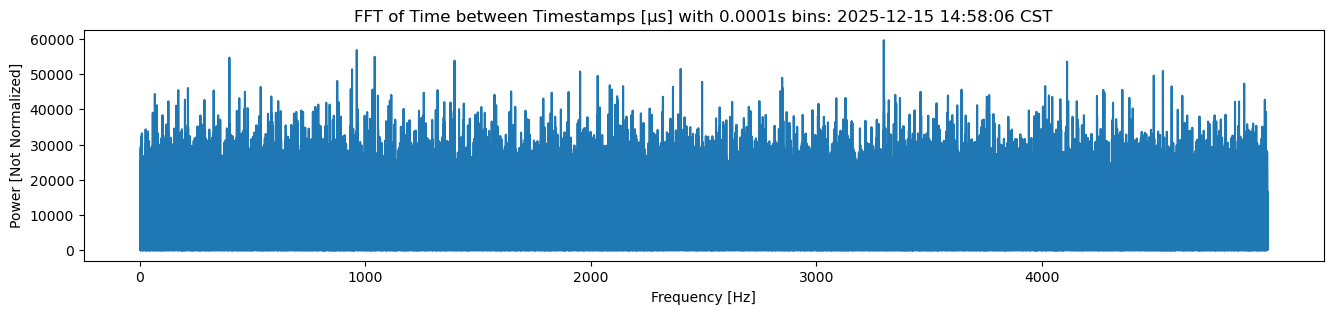

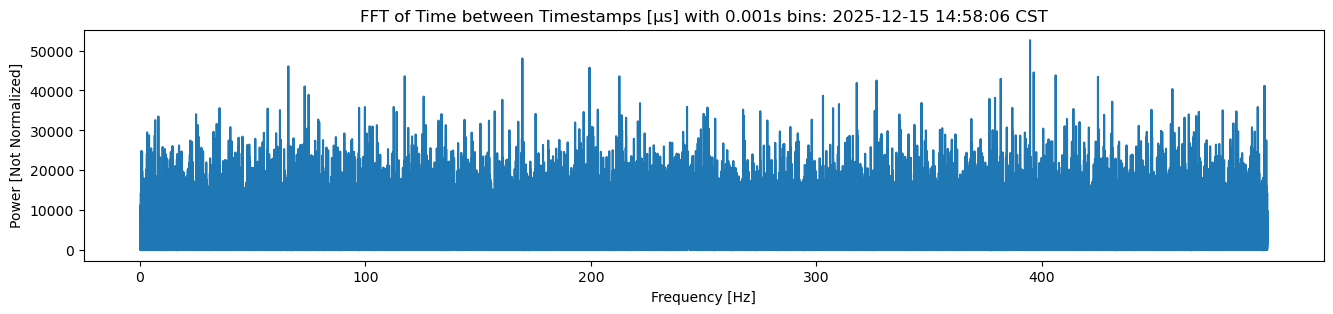

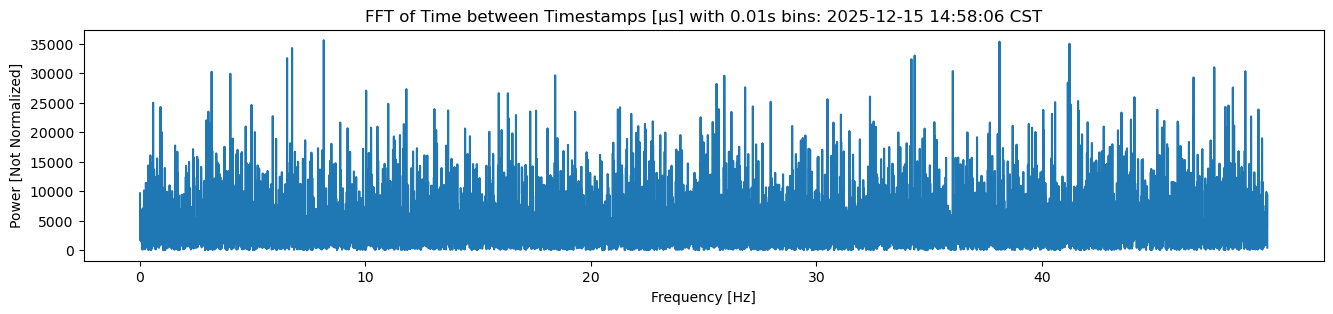

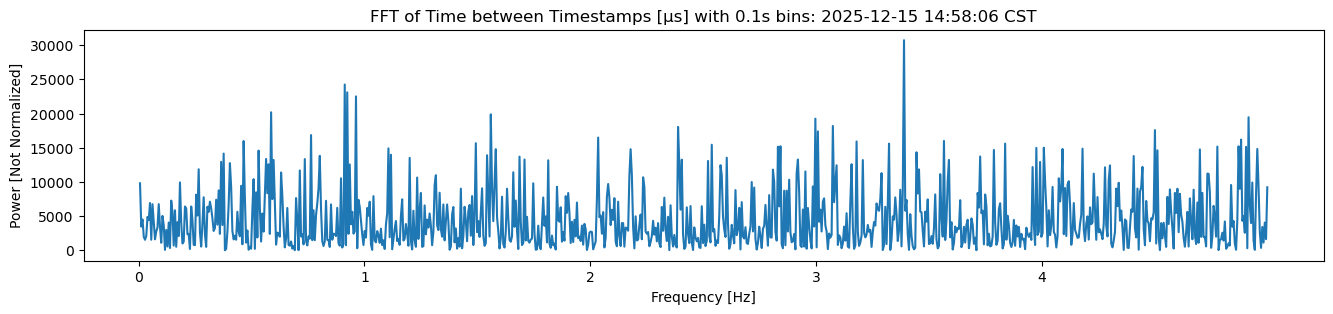

In [14]:
# 1) Choose a uniform bin size (sample interval) in seconds
timestamps = subsequent_ts[:,6] / 1e5 # in seconds
bin_ranges = np.array([0.0001, 0.001, 0.01, 0.1])
for dt in bin_ranges:
    #dt = bin_ranges[t] # 60s bins (1 minute). Choose based on your data and what periods you care about.

    t0 = timestamps.min()
    t1 = timestamps.max()

    # 2) Build bin edges and count events per bin
    edges = np.arange(t0, t1 + dt, dt)
    counts, _ = np.histogram(timestamps, bins=edges)

    # 3) Detrend/remove mean (important so DC doesn't dominate)
    x = counts.astype(float)
    x = x - x.mean()

    # Optional: window to reduce spectral leakage
    window = np.hanning(len(x))
    xw = x * window

    # 4) FFT (real FFT) and frequency axis
    X = np.fft.rfft(x)
    freq = np.fft.rfftfreq(len(x), d=dt)  # Hz = cycles/second

    power = np.abs(X)**2

    plt.figure(figsize=(16, 3))
    plt.plot(freq[1:], power[1:])  # skip DC
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power [Not Normalized]')
    plt.title(f'FFT of Time between Timestamps [μs] with {dt}s bins: {formatted_time}')
    plt.xticks(np.arange(0, max(freq), (1/dt)*0.1))
    plt.show()


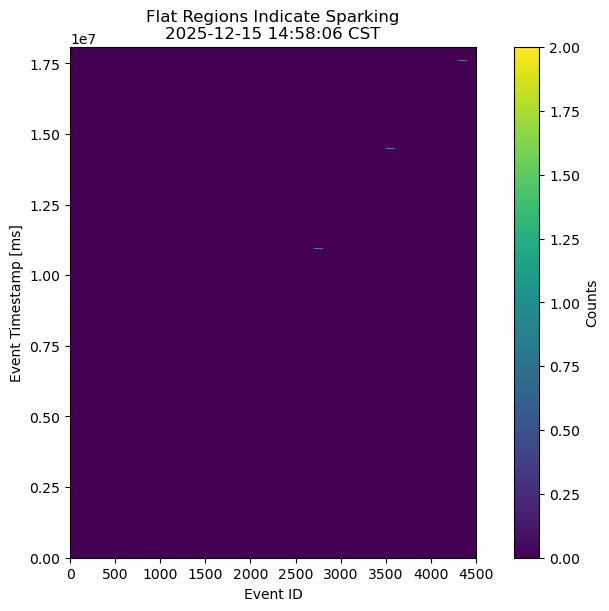

In [15]:
# ---- Bin definition ----
bin_size_x = 100 # width of each bin
bin_size_y = 100 # width of each bin
x_bins = np.arange(subsequent_ts[:,6].min(), subsequent_ts[:,6].max() + bin_size_x, bin_size_x)
y_bins = np.arange(event_ids[:].min(), event_ids[:].max() + bin_size_y, bin_size_y)

# ---- Colorbar range ----
vmin = 0     # minimum count shown
vmax = 2  # maximum count shown

# Create the 2D histogram
fig, ax = plt.subplots(figsize=(6, 6), layout='constrained')
hist = plt.hist2d(
    event_ids,
    subsequent_ts[:,6],
    bins=[y_bins, x_bins],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

# Colorbar
plt.colorbar(hist[3], label='Counts')

# Axis labels
plt.ylabel('Event Timestamp [ms]')
plt.xlabel('Event ID')
plt.title(f'Flat Regions Indicate Sparking\n{formatted_time}')

plt.show()

Full Event List:  [173, 360, 168, 264, 168, 173, 246, 249, 277, 343, 360, 391, 46, 168, 173, 213, 277, 310, 360, 391, 48, 64, 168, 173, 277, 360, 362, 46, 168, 173, 196, 213, 277, 310, 360, 391, 227, 264, 303, 391, 46, 264, 264, 391, 108, 168, 264, 386, 181, 173, 181, 190, 192, 384, 181, 384, 384, 158, 181, 384, 396, 34, 62, 181, 205, 357, 30, 76, 133, 162, 168, 181, 183, 215, 22, 60, 173, 181, 182, 351, 381, 134, 181, 243, 257, 31, 127, 181, 331, 374, 384, 87, 147, 164, 168, 181, 213, 275, 384, 389, 394, 6, 135, 168, 181, 188, 349, 384, 168, 178, 181, 316, 384, 18, 47, 131, 378, 23, 70, 115, 187, 263, 269, 391, 18, 47, 70, 131, 254, 378, 70, 187, 253, 366, 388, 391, 19, 131, 239, 333, 346, 378, 47, 57, 302, 391, 17, 47, 55, 58, 103, 129, 131, 189, 210, 237, 264, 313, 320, 342, 376, 378, 391, 393, 399, 47, 66, 78, 131, 193, 216, 279, 307, 368, 372, 378, 391, 18, 21, 35, 44, 47, 70, 79, 93, 121, 131, 149, 283, 378, 398, 18, 47, 70, 94, 131, 142, 187, 337, 370, 378, 391, 397, 18, 47, 70,

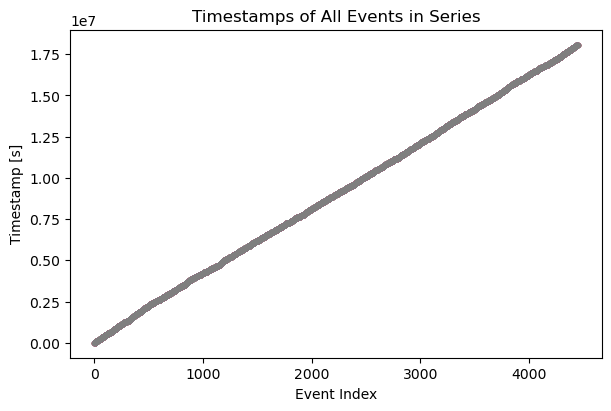

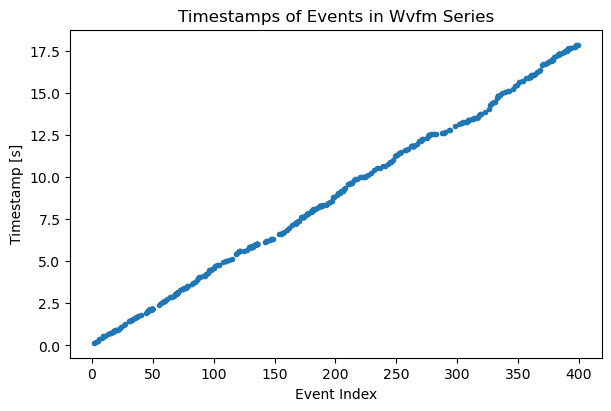

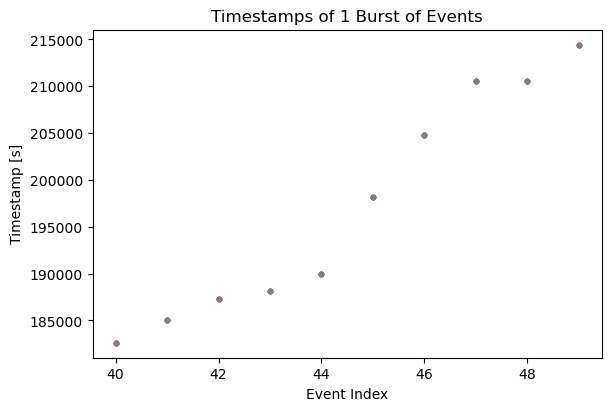

In [16]:
print('Full Event List: ', event_list)
print('Zoomed Event List: ', event_list[40:50])
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(np.array(event_ids), np.array(subsequent_ts), marker='o', linestyle='None', markersize=3)
ax.set_xlabel('Event Index')
ax.set_ylabel('Timestamp [s]')
ax.set_title('Timestamps of All Events in Series')
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(np.array(event_list), np.array(time_list)[:,7]/1e9, marker='o', linestyle='None', markersize=3)
ax.set_xlabel('Event Index')
ax.set_ylabel('Timestamp [s]')
ax.set_title('Timestamps of Events in Wvfm Series')
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(np.array(event_ids)[40:50], np.array(subsequent_ts)[40:50], marker='o', linestyle='None', markersize=3)
ax.set_xlabel('Event Index')
ax.set_ylabel('Timestamp [s]')
ax.set_title('Timestamps of 1 Burst of Events')
textstr = f'Approximately 850us Burst'
#textstr = f'Particle Type: protons\nVertex in 2x2'
props = dict(boxstyle='round', facecolor='white', edgecolor='black')

plt.show()